[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/veselm73/SU2/blob/main/notebooks/SU2_StarDist_inference.ipynb)

# StarDist Model Comparison: Detection & Tracking

**Authors:** Matyáš Veselý, Ruslan Guliev

This notebook compares **3 cell detection methods** on TIRF-SIM microscopy images:

1. **StarDist (No Bonus)** - 100 epochs, no augmentation, 64 rays, no bonus training data
2. **StarDist (Original)** - 100 epochs, no augmentation, 64 rays, with bonus training data
3. **SOTA Method** - State-of-the-art baseline from competition

All methods are evaluated using **LapTrack** for cell tracking.

---

## Model Overview

**StarDist** is a deep learning method for object detection that predicts star-convex polygons for each object. Key features:

- **Architecture**: ResNet18 encoder + StarDist decoder with 64 radial rays
- **Training**: 5-fold cross-validation ensemble (predictions averaged)
- **Output**: Probability map + 64 ray distances → NMS → centroid coordinates

### Training Configuration

| Parameter | Value |
|-----------|-------|
| Encoder | ResNet18 |
| N_Rays | 64 |
| Epochs | 100 |
| Augmentation | None |
| Input Size | 256×256 (ROI crop) |
| Normalization | Percentile (1st, 99.8th) |

### Model Differences

| Model | NMS Threshold | Description |
|-------|---------------|-------------|
| StarDist (No Bonus) | 0.2 | Trained without bonus data |
| StarDist (Original) | 0.35 | Trained with bonus data |

---

## 1. Setup

In [1]:
# Install dependencies
!pip install uv -q
!uv pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121 --system -q
!uv pip install "numpy<2" cellseg-models-pytorch pytorch-lightning tifffile scipy laptrack tabulate --system -q

In [2]:
import sys
import os
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    if not Path('/content/SU2').exists():
        !git clone https://github.com/veselm73/SU2.git /content/SU2
    else:
        # Pull latest changes if repo already exists
        !cd /content/SU2 && git pull
    os.chdir('/content/SU2')
    repo_root = Path('/content/SU2')
else:
    repo_root = Path('.').resolve()
    if repo_root.name == 'notebooks':
        repo_root = repo_root.parent

print(f"Repository: {repo_root}")

Already up to date.
Repository: /content/SU2


In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from skimage.measure import regionprops
import urllib.request
import json
import tifffile
import networkx as nx
from scipy import spatial
from scipy.optimize import linear_sum_assignment
from laptrack import LapTrack

from cellseg_models_pytorch.postproc.functional.stardist.stardist import post_proc_stardist

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

Device: cuda


## 2. Model Weight Paths

Configure paths to the two StarDist model weight directories.

In [4]:
# Model weight paths - adjust these for your environment
if IN_COLAB:
    # Colab: weights/ folder has no 'competition' subfolder
    WEIGHTS_NOBONUS_DIR = repo_root / "weights" / "100e_noaug_64rays_nobonus"
    WEIGHTS_ORIGINAL_DIR = repo_root / "weights" / "100e_noaug_64rays"
else:
    # Local: ansamble_weights/ folder has 'competition' subfolder
    WEIGHTS_NOBONUS_DIR = Path(r"C:\Users\Mateusz\SU2\ansamble_weights\100e_noaug_64rays_nobonus\competition")
    WEIGHTS_ORIGINAL_DIR = Path(r"C:\Users\Mateusz\SU2\ansamble_weights\100e_noaug_64rays\competition")

print(f"StarDist (No Bonus) weights: {WEIGHTS_NOBONUS_DIR}")
print(f"StarDist (Original) weights: {WEIGHTS_ORIGINAL_DIR}")

# Verify weights exist
for name, path in [("No Bonus", WEIGHTS_NOBONUS_DIR), ("Original", WEIGHTS_ORIGINAL_DIR)]:
    models_dir = path / "models"
    if models_dir.exists():
        n_weights = len(list(models_dir.glob("*.pth")))
        print(f"  {name}: Found {n_weights} fold weights")
    else:
        print(f"  {name}: WARNING - weights not found at {models_dir}")

StarDist (No Bonus) weights: /content/SU2/weights/100e_noaug_64rays_nobonus
StarDist (Original) weights: /content/SU2/weights/100e_noaug_64rays
  No Bonus: Found 5 fold weights
  Original: Found 5 fold weights


## 3. Model Definition & Loading

In [5]:
import pytorch_lightning as pl
from cellseg_models_pytorch.models.stardist.stardist import StarDist

class StarDistModel(pl.LightningModule):
    def __init__(self, n_rays=64, encoder_name="resnet18"):
        super().__init__()
        self.n_rays = n_rays
        wrapper = StarDist(
            n_nuc_classes=1, n_rays=n_rays, enc_name=encoder_name,
            model_kwargs={"encoder_kws": {"in_chans": 1}}
        )
        self.model = wrapper.model

    def forward(self, x):
        return self.model(x)


def load_ensemble(weights_dir, name="Model"):
    """Load 5-fold ensemble from a weights directory."""
    with open(weights_dir / "model_config.json") as f:
        config = json.load(f)
    with open(weights_dir / "inference_config.json") as f:
        inf_config = json.load(f)

    models = []
    for fold in range(1, 6):
        model = StarDistModel(n_rays=config['n_rays'], encoder_name=config['encoder_name'])
        model.load_state_dict(torch.load(weights_dir / "models" / f"fold_{fold}.pth", map_location='cpu'))
        model.eval().to(DEVICE)
        models.append(model)

    print(f"[{name}] Loaded {len(models)} models: {config['encoder_name']}, n_rays={config['n_rays']}")
    print(f"[{name}] Thresholds: prob={inf_config['prob_thresh']}, nms={inf_config['nms_thresh']}")

    return models, inf_config


# Load both ensembles
print("Loading StarDist (No Bonus) ensemble...")
models_nobonus, config_nobonus = load_ensemble(WEIGHTS_NOBONUS_DIR, "No Bonus")

print("\nLoading StarDist (Original) ensemble...")
models_original, config_original = load_ensemble(WEIGHTS_ORIGINAL_DIR, "Original")

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading StarDist (No Bonus) ensemble...


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

[No Bonus] Loaded 5 models: resnet18, n_rays=64
[No Bonus] Thresholds: prob=0.6, nms=0.2

Loading StarDist (Original) ensemble...
[Original] Loaded 5 models: resnet18, n_rays=64
[Original] Thresholds: prob=0.6, nms=0.35


## 4. Inference Functions

In [6]:
# ROI configuration
ROI = {'x_min': 256, 'x_max': 512, 'y_min': 512, 'y_max': 768}

def preprocess(frame):
    """Percentile normalization."""
    frame = frame.astype(np.float32)
    p1, p99 = np.percentile(frame, (1, 99.8))
    return np.clip((frame - p1) / (p99 - p1 + 1e-8), 0, 1)


def detect_single_frame(models, frame, prob_thresh, nms_thresh):
    """Run ensemble detection on a single frame."""
    x = torch.from_numpy(frame).float().unsqueeze(0).unsqueeze(0).to(DEVICE)

    all_stardist, all_prob = [], []
    with torch.no_grad():
        for model in models:
            out = model(x)['nuc']
            all_stardist.append(out.aux_map.cpu().numpy()[0])
            all_prob.append(torch.sigmoid(out.binary_map).cpu().numpy()[0, 0])

    try:
        labels = post_proc_stardist(
            np.mean(all_prob, axis=0), np.mean(all_stardist, axis=0),
            score_thresh=prob_thresh, iou_thresh=nms_thresh
        )
        return [(p.centroid[1], p.centroid[0]) for p in regionprops(labels)]
    except:
        return []


def run_detection(video, models, prob_thresh, nms_thresh, roi=None):
    """Run detection on entire video."""
    if roi:
        video_roi = video[:, roi['y_min']:roi['y_max'], roi['x_min']:roi['x_max']]
    else:
        video_roi = video
        roi = {'x_min': 0, 'y_min': 0}

    all_detections = []
    detections_per_frame = []

    for frame_idx in tqdm(range(len(video_roi)), desc="Detecting"):
        frame = preprocess(video_roi[frame_idx])
        dets = detect_single_frame(models, frame, prob_thresh, nms_thresh)

        # Store for tracking (local coords)
        detections_per_frame.append(dets)

        # Store for output (global coords)
        for x, y in dets:
            all_detections.append({
                'frame': frame_idx,
                'x': x + roi['x_min'],
                'y': y + roi['y_min']
            })

    return pd.DataFrame(all_detections), detections_per_frame

print("Inference functions defined.")

Inference functions defined.


## 5. Tracking with LapTrack

**LapTrack** uses Linear Assignment Problem (LAP) optimization for frame-to-frame linking with gap closing.

Best configuration from benchmark (HOTA=0.9406):
- `track_cost_cutoff`: 25 (5px squared)
- `gap_closing_cost_cutoff`: 49 (7px squared)  
- `gap_closing_max_frame_count`: 1

In [7]:
# Best LapTrack configuration (HOTA=0.9406 on GT benchmark)
LAPTRACK_CONFIG = {
    'track_cost_cutoff': 25,        # 5px squared
    'gap_closing_cost_cutoff': 49,  # 7px squared
    'gap_closing_max_frame_count': 1
}

def run_tracking(detections_per_frame, config=LAPTRACK_CONFIG):
    """Track detections using LapTrack."""
    if len(detections_per_frame) == 0:
        return pd.DataFrame(columns=['frame', 'x', 'y', 'track_id'])

    # Prepare coordinates
    coords_per_frame = []
    for dets in detections_per_frame:
        if len(dets) > 0:
            coords_per_frame.append(np.array([[x, y] for x, y in dets]))
        else:
            coords_per_frame.append(np.empty((0, 2)))

    # Run tracking
    tracker = LapTrack(
        track_cost_cutoff=config['track_cost_cutoff'],
        gap_closing_cost_cutoff=config['gap_closing_cost_cutoff'],
        gap_closing_max_frame_count=config['gap_closing_max_frame_count']
    )

    graph = tracker.predict(coords_per_frame)

    # Extract tracks
    records = []
    for track_id, component in enumerate(nx.weakly_connected_components(graph)):
        for node in component:
            frame_idx, det_idx = node
            if frame_idx < len(coords_per_frame) and det_idx < len(coords_per_frame[frame_idx]):
                x, y = coords_per_frame[frame_idx][det_idx]
                records.append({'frame': int(frame_idx), 'x': float(x), 'y': float(y), 'track_id': int(track_id)})

    if not records:
        return pd.DataFrame(columns=['frame', 'x', 'y', 'track_id'])

    return pd.DataFrame(records).sort_values(['track_id', 'frame']).reset_index(drop=True)

print(f"LapTrack config: track={np.sqrt(LAPTRACK_CONFIG['track_cost_cutoff']):.0f}px, gap={np.sqrt(LAPTRACK_CONFIG['gap_closing_cost_cutoff']):.0f}px, max_frames={LAPTRACK_CONFIG['gap_closing_max_frame_count']}")

LapTrack config: track=5px, gap=7px, max_frames=1


In [8]:
import os
import io
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload

# 1. Authenticate user to access Drive
print("Authenticating... Please allow access in the popup.")
auth.authenticate_user()

# 2. Setup Drive Service
drive_service = build('drive', 'v3')
folder_id = '1sinaukYGrv9k4Ao0PsOyuillk6vQ5SyF'
destination_dir = '/content/SU2/data/test_and_sota'

# 3. Create destination directory
os.makedirs(destination_dir, exist_ok=True)

# 4. List files in the Drive folder
query = f"'{folder_id}' in parents and trashed = false"
results = drive_service.files().list(q=query, fields="files(id, name)").execute()
files = results.get('files', [])

print(f"Found {len(files)} files in Drive folder.")

# 5. Download files
for file in files:
    file_id = file['id']
    file_name = file['name']
    save_path = os.path.join(destination_dir, file_name)

    print(f"Downloading {file_name}...")
    request = drive_service.files().get_media(fileId=file_id)

    with io.FileIO(save_path, 'wb') as fh:
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while done is False:
            status, done = downloader.next_chunk()

print("\nDownload complete. Files in target directory:")
for f in os.listdir(destination_dir):
    print(f" - {f}")

Authenticating... Please allow access in the popup.


Found 3 files in Drive folder.

Download complete. Files in target directory:
 - val.tif
 - val.csv
 - sota.csv


---

## 6. Load Test Data

Load the validation video and annotations from the local `data/test_and_sota` folder.

In [9]:
# Load test data from local folder
DATA_DIR = repo_root / "data" / "test_and_sota"

# Load video
VIDEO_PATH = DATA_DIR / "val.tif"
video = tifffile.imread(VIDEO_PATH)
print(f"Loaded: {VIDEO_PATH}")
print(f"Shape: {video.shape} (frames, height, width)")

# Load ground truth annotations
GT_PATH = DATA_DIR / "val.csv"
gt_df = pd.read_csv(GT_PATH)
print(f"\nGround truth: {len(gt_df)} detections, {gt_df['track_id'].nunique()} tracks")

# Load SOTA predictions
SOTA_PATH = DATA_DIR / "sota.csv"
sota_df = pd.read_csv(SOTA_PATH)
print(f"SOTA predictions: {len(sota_df)} detections, {sota_df['track_id'].nunique()} tracks")

Loaded: /content/SU2/data/test_and_sota/val.tif
Shape: (722, 1024, 1024) (frames, height, width)

Ground truth: 35688 detections, 438 tracks
SOTA predictions: 31606 detections, 406 tracks


In [10]:
# Run detection for both models
print("="*60)
print("Running Detection for Both StarDist Models")
print("="*60)

# StarDist (No Bonus)
print("\n[1/2] StarDist (No Bonus)...")
detections_nobonus_df, detections_nobonus_per_frame = run_detection(
    video, models_nobonus,
    config_nobonus['prob_thresh'], config_nobonus['nms_thresh'],
    roi=ROI
)
print(f"  Detected {len(detections_nobonus_df)} cells ({len(detections_nobonus_df)/len(video):.1f}/frame)")

# StarDist (Original)
print("\n[2/2] StarDist (Original)...")
detections_original_df, detections_original_per_frame = run_detection(
    video, models_original,
    config_original['prob_thresh'], config_original['nms_thresh'],
    roi=ROI
)
print(f"  Detected {len(detections_original_df)} cells ({len(detections_original_df)/len(video):.1f}/frame)")

print("\nDetection complete for both models.")

Running Detection for Both StarDist Models

[1/2] StarDist (No Bonus)...


Detecting:   0%|          | 0/722 [00:00<?, ?it/s]

  Detected 34143 cells (47.3/frame)

[2/2] StarDist (Original)...


Detecting:   0%|          | 0/722 [00:00<?, ?it/s]

  Detected 33742 cells (46.7/frame)

Detection complete for both models.


In [11]:
# Run tracking for both models
print("="*60)
print("Running Tracking for Both StarDist Models")
print("="*60)

# StarDist (No Bonus)
print("\n[1/2] Tracking StarDist (No Bonus)...")
tracks_nobonus_df = run_tracking(detections_nobonus_per_frame)
tracks_nobonus_df['x'] += ROI['x_min']
tracks_nobonus_df['y'] += ROI['y_min']
print(f"  Found {tracks_nobonus_df['track_id'].nunique()} tracks")
print(f"  Avg track length: {tracks_nobonus_df.groupby('track_id').size().mean():.1f} frames")

# StarDist (Original)
print("\n[2/2] Tracking StarDist (Original)...")
tracks_original_df = run_tracking(detections_original_per_frame)
tracks_original_df['x'] += ROI['x_min']
tracks_original_df['y'] += ROI['y_min']
print(f"  Found {tracks_original_df['track_id'].nunique()} tracks")
print(f"  Avg track length: {tracks_original_df.groupby('track_id').size().mean():.1f} frames")

print("\nTracking complete for both models.")

Running Tracking for Both StarDist Models

[1/2] Tracking StarDist (No Bonus)...
  Found 2595 tracks
  Avg track length: 13.2 frames

[2/2] Tracking StarDist (Original)...
  Found 2405 tracks
  Avg track length: 14.0 frames

Tracking complete for both models.


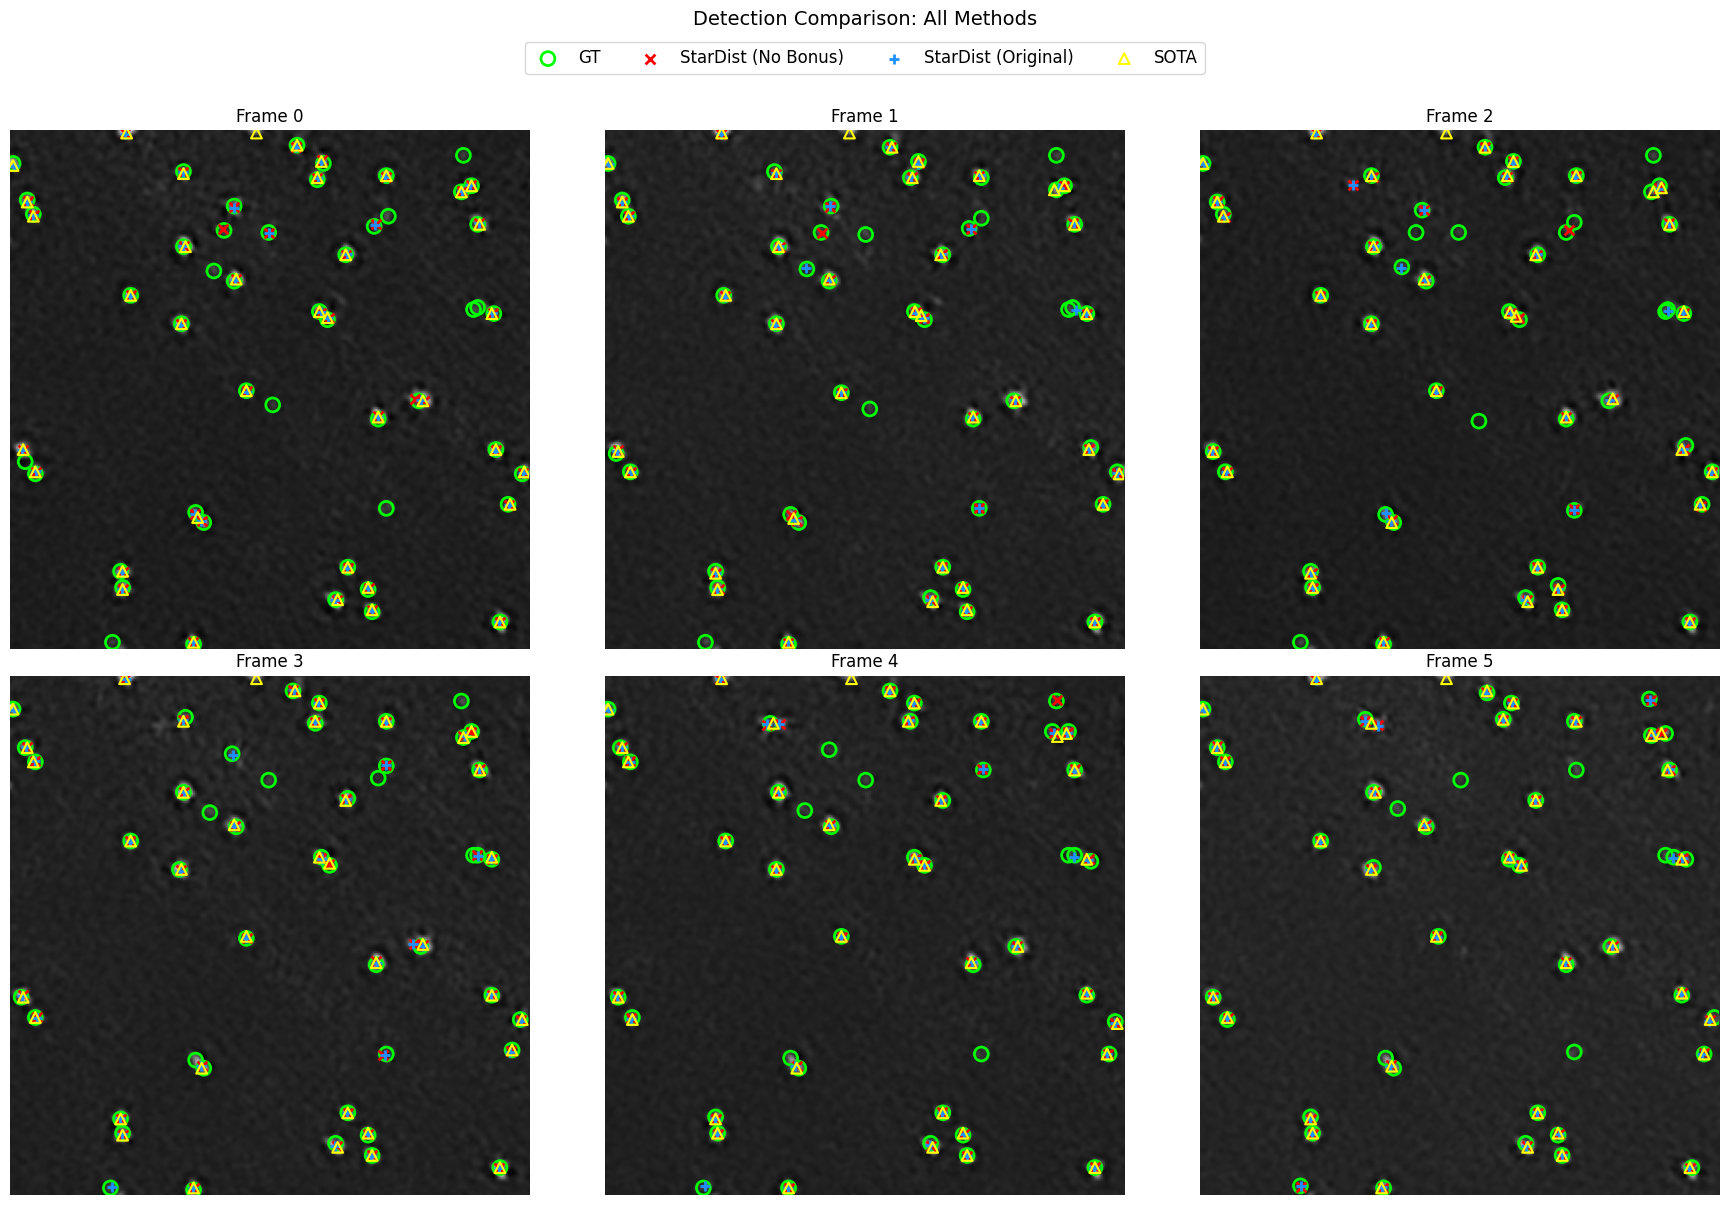

In [12]:
# Visual Comparison: GT vs StarDist (No Bonus) vs StarDist (Original) vs SOTA
num_frames = 6
start_frame = 0
cols = 3
rows = 2

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()

for i in range(num_frames):
    frame_idx = start_frame + i
    ax = axes[i]

    # ROI crop
    roi_frame = video[frame_idx, ROI['y_min']:ROI['y_max'], ROI['x_min']:ROI['x_max']]
    ax.imshow(roi_frame, cmap='gray')

    # Ground Truth (Green Circles)
    gt_frame = gt_df[gt_df['frame'] == frame_idx]
    if len(gt_frame) > 0:
        ax.scatter(gt_frame['x'] - ROI['x_min'], gt_frame['y'] - ROI['y_min'],
                   edgecolor='lime', s=100, marker='o', facecolors='none', linewidths=2,
                   label='GT' if i==0 else "")

    # StarDist (No Bonus) - Red X
    nobonus_frame = detections_nobonus_df[detections_nobonus_df['frame'] == frame_idx]
    if len(nobonus_frame) > 0:
        ax.scatter(nobonus_frame['x'] - ROI['x_min'], nobonus_frame['y'] - ROI['y_min'],
                   c='red', s=50, marker='x', linewidths=2,
                   label='StarDist (No Bonus)' if i==0 else "")

    # StarDist (Original) - Blue +
    original_frame = detections_original_df[detections_original_df['frame'] == frame_idx]
    if len(original_frame) > 0:
        ax.scatter(original_frame['x'] - ROI['x_min'], original_frame['y'] - ROI['y_min'],
                   c='dodgerblue', s=50, marker='+', linewidths=2,
                   label='StarDist (Original)' if i==0 else "")

    # SOTA - Yellow triangles
    sota_frame = sota_df[sota_df['frame'] == frame_idx]
    if len(sota_frame) > 0:
        ax.scatter(sota_frame['x'] - ROI['x_min'], sota_frame['y'] - ROI['y_min'],
                   edgecolor='yellow', s=60, marker='^', facecolors='none', linewidths=1.5,
                   label='SOTA' if i==0 else "")

    ax.set_title(f'Frame {frame_idx}', fontsize=12)
    ax.axis('off')

# Legend
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=12, frameon=True,
               bbox_to_anchor=(0.5, 0.98))

plt.suptitle('Detection Comparison: All Methods', fontsize=14, y=1.0)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

---

## 7. Evaluation Metrics

Calculate HOTA, DetA, and AssA metrics for all three methods.

In [13]:
# Evaluation metric functions
def calculate_deta(gt_df, pred_df, match_thresh=5.0):
    """Calculate Detection Accuracy (DetA) using Hungarian matching."""
    gt_df = gt_df.copy()
    pred_df = pred_df.copy()
    gt_df['frame'] = gt_df['frame'].astype(int)
    pred_df['frame'] = pred_df['frame'].astype(int)

    total_tp, total_fp, total_fn = 0, 0, 0

    for frame in gt_df['frame'].unique():
        gt_frame = gt_df[gt_df['frame'] == frame][['x', 'y']].values
        pred_frame = pred_df[pred_df['frame'] == frame][['x', 'y']].values

        if len(gt_frame) == 0:
            total_fp += len(pred_frame)
            continue
        if len(pred_frame) == 0:
            total_fn += len(gt_frame)
            continue

        dist_matrix = spatial.distance.cdist(gt_frame, pred_frame)
        row_ind, col_ind = linear_sum_assignment(dist_matrix)
        matches = sum(dist_matrix[row_ind[i], col_ind[i]] <= match_thresh for i in range(len(row_ind)))

        total_tp += matches
        total_fp += len(pred_frame) - matches
        total_fn += len(gt_frame) - matches

    deta = total_tp / max(1, total_tp + total_fp + total_fn)
    return deta, {'TP': total_tp, 'FP': total_fp, 'FN': total_fn}


def hota(gt: pd.DataFrame, tr: pd.DataFrame, threshold: float = 5) -> dict:
    """Calculate HOTA (Higher Order Tracking Accuracy) metric."""
    gt = gt.copy()
    tr = tr.copy()

    if 'track_id' not in gt.columns or 'track_id' not in tr.columns:
        return {'HOTA': 0.0, 'AssA': 0.0, 'DetA': 0.0}
    if gt.empty or tr.empty:
        return {'HOTA': 0.0, 'AssA': 0.0, 'DetA': 0.0}

    gt.track_id = gt.track_id.map({old: new for old, new in zip(gt.track_id.unique(), range(gt.track_id.nunique()))})
    tr.track_id = tr.track_id.map({old: new for old, new in zip(tr.track_id.unique(), range(tr.track_id.nunique()))})

    num_gt_ids = gt.track_id.nunique()
    num_tr_ids = tr.track_id.nunique()

    matches_count = np.zeros((num_gt_ids, num_tr_ids))
    gt_id_count = np.zeros((num_gt_ids, 1))
    tracker_id_count = np.zeros((1, num_tr_ids))
    HOTA_TP = HOTA_FN = HOTA_FP = 0

    similarities = [1 - np.clip(spatial.distance.cdist(
        gt[gt.frame == t][['x', 'y']].values,
        tr[tr.frame == t][['x', 'y']].values
    ) / threshold, 0, 1) for t in range(int(gt.frame.max()) + 1)]

    for t in range(int(gt.frame.max()) + 1):
        gt_ids_t = gt[gt.frame == t].track_id.to_numpy()
        tr_ids_t = tr[tr.frame == t].track_id.to_numpy()

        gt_id_count[gt_ids_t] += 1
        tracker_id_count[:, tr_ids_t] += 1

        if len(gt_ids_t) == 0:
            HOTA_FP += len(tr_ids_t)
            continue
        if len(tr_ids_t) == 0:
            HOTA_FN += len(gt_ids_t)
            continue

        similarity = similarities[t]
        match_rows, match_cols = linear_sum_assignment(-similarity)
        mask = similarity[match_rows, match_cols] > 0
        alpha_match_rows = match_rows[mask]
        alpha_match_cols = match_cols[mask]
        num_matches = len(alpha_match_rows)

        HOTA_TP += num_matches
        HOTA_FN += len(gt_ids_t) - num_matches
        HOTA_FP += len(tr_ids_t) - num_matches

        if num_matches > 0:
            matches_count[gt_ids_t[alpha_match_rows], tr_ids_t[alpha_match_cols]] += 1

    ass_a = matches_count / np.maximum(1, gt_id_count + tracker_id_count - matches_count)
    AssA = np.sum(matches_count * ass_a) / np.maximum(1, HOTA_TP)
    DetA = HOTA_TP / np.maximum(1, HOTA_TP + HOTA_FN + HOTA_FP)
    HOTA_score = np.sqrt(DetA * AssA)

    return {'HOTA': float(HOTA_score), 'AssA': float(AssA), 'DetA': float(DetA)}

print("Evaluation functions defined.")

Evaluation functions defined.


In [14]:
# Calculate metrics for all three methods
print("="*70)
print("COMPUTING HOTA METRICS FOR ALL METHODS")
print("="*70)

# StarDist (No Bonus)
print("\n[1/3] StarDist (No Bonus)...")
hota_nobonus = hota(gt_df, tracks_nobonus_df)
print(f"  HOTA={hota_nobonus['HOTA']:.4f}, DetA={hota_nobonus['DetA']:.4f}, AssA={hota_nobonus['AssA']:.4f}")

# StarDist (Original)
print("\n[2/3] StarDist (Original)...")
hota_original = hota(gt_df, tracks_original_df)
print(f"  HOTA={hota_original['HOTA']:.4f}, DetA={hota_original['DetA']:.4f}, AssA={hota_original['AssA']:.4f}")

# SOTA
print("\n[3/3] SOTA...")
hota_sota = hota(gt_df, sota_df)
print(f"  HOTA={hota_sota['HOTA']:.4f}, DetA={hota_sota['DetA']:.4f}, AssA={hota_sota['AssA']:.4f}")

print("\nMetric computation complete.")

# ============================================================
# FINAL COMPARISON TABLE
# ============================================================
print("\n" + "="*70)
print("FINAL COMPARISON TABLE")
print("="*70)

comparison_df = pd.DataFrame({
    'Method': ['StarDist (No Bonus)', 'StarDist (Original)', 'SOTA'],
    'DetA': [hota_nobonus['DetA'], hota_original['DetA'], hota_sota['DetA']],
    'AssA': [hota_nobonus['AssA'], hota_original['AssA'], hota_sota['AssA']],
    'HOTA': [hota_nobonus['HOTA'], hota_original['HOTA'], hota_sota['HOTA']],
    'Tracks': [tracks_nobonus_df['track_id'].nunique(),
               tracks_original_df['track_id'].nunique(),
               sota_df['track_id'].nunique()],
    'Detections': [len(tracks_nobonus_df), len(tracks_original_df), len(sota_df)]
})

# Sort by HOTA (best first)
comparison_df = comparison_df.sort_values('HOTA', ascending=False).reset_index(drop=True)

# Display formatted table
print("\n" + comparison_df.to_string(index=False, float_format=lambda x: f"{x:.4f}" if isinstance(x, float) else str(x)))

# Ground truth reference
print(f"\n[Ground Truth: {gt_df['track_id'].nunique()} tracks, {len(gt_df)} detections]")

# Highlight best method
best_method = comparison_df.iloc[0]['Method']
best_hota = comparison_df.iloc[0]['HOTA']
print(f"\nBest Method: {best_method} (HOTA = {best_hota:.4f})")

COMPUTING HOTA METRICS FOR ALL METHODS

[1/3] StarDist (No Bonus)...
  HOTA=0.6764, DetA=0.7996, AssA=0.5722

[2/3] StarDist (Original)...
  HOTA=0.6904, DetA=0.8046, AssA=0.5923

[3/3] SOTA...
  HOTA=0.6848, DetA=0.7703, AssA=0.6088

Metric computation complete.

FINAL COMPARISON TABLE

             Method   DetA   AssA   HOTA  Tracks  Detections
StarDist (Original) 0.8046 0.5923 0.6904    2405       33742
               SOTA 0.7703 0.6088 0.6848     406       31606
StarDist (No Bonus) 0.7996 0.5722 0.6764    2595       34143

[Ground Truth: 438 tracks, 35688 detections]

Best Method: StarDist (Original) (HOTA = 0.6904)


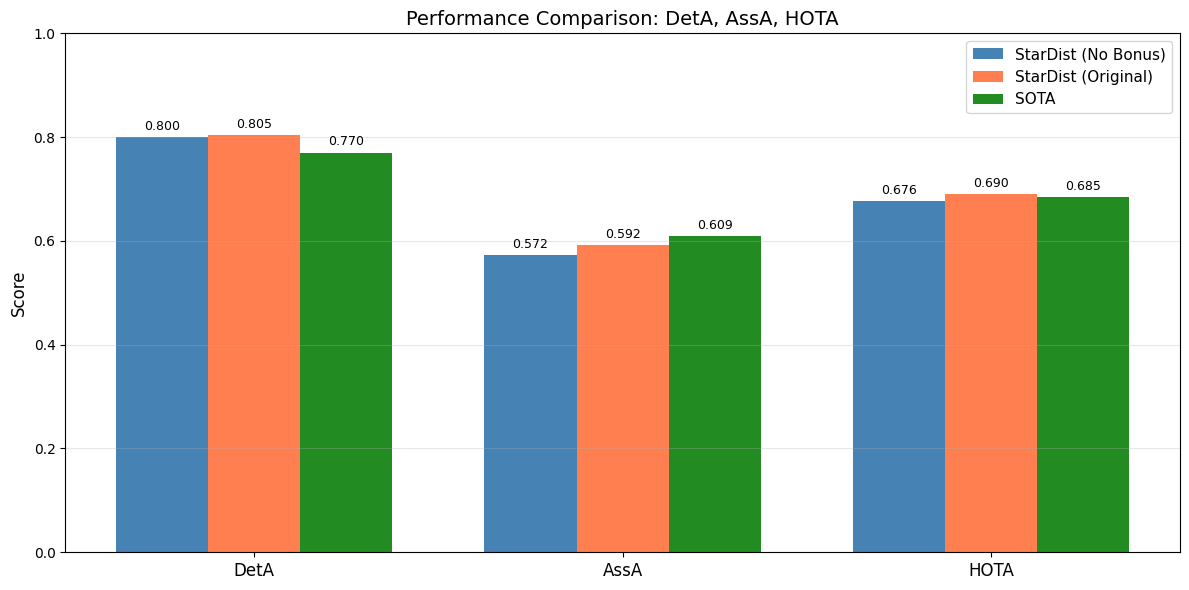


FINAL RESULTS TABLE

| Method              |   DetA |   AssA |   HOTA |   Tracks |   Detections |
|:--------------------|-------:|-------:|-------:|---------:|-------------:|
| StarDist (Original) | 0.8046 | 0.5923 | 0.6904 |     2405 |        33742 |
| SOTA                | 0.7703 | 0.6088 | 0.6848 |      406 |        31606 |
| StarDist (No Bonus) | 0.7996 | 0.5722 | 0.6764 |     2595 |        34143 |



In [15]:
# Bar chart comparison of all 3 methods
fig, ax = plt.subplots(figsize=(12, 6))

metrics = ['DetA', 'AssA', 'HOTA']
x = np.arange(len(metrics))
width = 0.25

# Get values in original order
methods_data = {
    'StarDist (No Bonus)': hota_nobonus,
    'StarDist (Original)': hota_original,
    'SOTA': hota_sota
}
colors = ['steelblue', 'coral', 'forestgreen']

bars = []
for i, (method, data) in enumerate(methods_data.items()):
    values = [data[m] for m in metrics]
    bar = ax.bar(x + (i - 1) * width, values, width, label=method, color=colors[i])
    bars.append(bar)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance Comparison: DetA, AssA, HOTA', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=11)
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# ============================================================
# Display styled comparison table
# ============================================================
print("\n" + "="*70)
print("FINAL RESULTS TABLE")
print("="*70 + "\n")

# Create nicely formatted display table
display_df = comparison_df.copy()
display_df['DetA'] = display_df['DetA'].apply(lambda x: f"{x:.4f}")
display_df['AssA'] = display_df['AssA'].apply(lambda x: f"{x:.4f}")
display_df['HOTA'] = display_df['HOTA'].apply(lambda x: f"{x:.4f}")

print(display_df.to_markdown(index=False))
print("\n" + "="*70)

---

## Summary

This notebook compares **3 cell detection methods** on the TIRF-SIM validation dataset:

| Method | Description |
|--------|-------------|
| **StarDist (No Bonus)** | 100 epochs, 64 rays, NMS=0.2, trained without bonus data |
| **StarDist (Original)** | 100 epochs, 64 rays, NMS=0.35, trained with bonus data |
| **SOTA** | State-of-the-art baseline from competition |

### Pipeline:
1. Load model weights from local `ansamble_weights/` directory (or GitHub for Colab)
2. Load test data from Google Drive (val.tif, val.csv, sota.csv)
3. Run cell detection with both StarDist models
4. Run **LapTrack** tracking on detections
5. Compare all methods using **HOTA, DetA, AssA** metrics

### Metrics Explained:
- **DetA** (Detection Accuracy): Measures detection quality per frame
- **AssA** (Association Accuracy): Measures track association quality
- **HOTA** (Higher Order Tracking Accuracy): Geometric mean of DetA and AssA

For questions or issues, see: https://github.com/veselm73/SU2